<a href="https://colab.research.google.com/github/kamijoseph/week-3-assignment/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from pathlib import Path

In [7]:
# Configuration
SEED = 42
BATCH_SIZE = 128
EPOCHS = 12
LR = 1e-3
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT = MODEL_DIR / "mnist_cnn_tf.keras"

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [9]:
# adding channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [10]:
# Split validation set (10% of train)
val_split = 0.1
val_size = int(len(x_train) * val_split)
x_val, y_val = x_train[-val_size:], y_train[-val_size:]
x_train, y_train = x_train[:-val_size], y_train[:-val_size]

In [11]:
# Create tf.data pipelines for efficiency
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
# building the model
def build_model():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [13]:
model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 872,426 (3.33 MB)

 Trainable params: 871,530 (3.32 MB)

 Non-trainable params: 896 (3.50 KB)

In [14]:
# compiling the model
optimizer = keras.optimizers.Adam(learning_rate=LR)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [15]:
# callbacks: early stopping & checkpoint
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT, monitor="val_accuracy", save_best_only=True)
]

In [16]:
# training the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/12
422/422 - 23s - 54ms/step - accuracy: 0.9428 - loss: 0.1858 - val_accuracy: 0.6953 - val_loss: 0.9573
Epoch 2/12
422/422 - 4s - 10ms/step - accuracy: 0.9810 - loss: 0.0614 - val_accuracy: 0.9895 - val_loss: 0.0357
Epoch 3/12
422/422 - 4s - 10ms/step - accuracy: 0.9851 - loss: 0.0487 - val_accuracy: 0.9900 - val_loss: 0.0312
Epoch 4/12
422/422 - 5s - 12ms/step - accuracy: 0.9889 - loss: 0.0357 - val_accuracy: 0.9925 - val_loss: 0.0281
Epoch 5/12
422/422 - 4s - 10ms/step - accuracy: 0.9895 - loss: 0.0330 - val_accuracy: 0.9922 - val_loss: 0.0289
Epoch 6/12
422/422 - 5s - 12ms/step - accuracy: 0.9909 - loss: 0.0292 - val_accuracy: 0.9937 - val_loss: 0.0223
Epoch 7/12
422/422 - 4s - 10ms/step - accuracy: 0.9922 - loss: 0.0262 - val_accuracy: 0.9923 - val_loss: 0.0266
Epoch 8/12
422/422 - 4s - 10ms/step - accuracy: 0.9911 - loss: 0.0265 - val_accuracy: 0.9937 - val_loss: 0.0268
Epoch 9/12
422/422 - 4s - 10ms/step - accuracy: 0.9928 - loss: 0.0219 - val_accuracy: 0.9918 - val_loss

In [17]:
# evaluation
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\nFinal test accuracy: {test_acc * 100:.2f}% | test loss: {test_loss:.4f}")


Final test accuracy: 99.36% | test loss: 0.0189


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


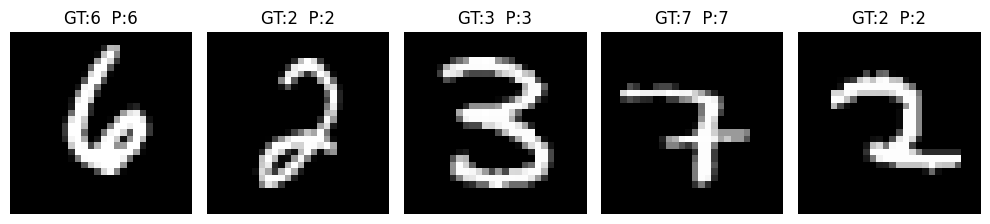

In [18]:
# visualizating: sample predictions
def visualize_predictions(model, x_data, y_data, n=5):
    idx = np.random.choice(len(x_data), n, replace=False)
    images, labels = x_data[idx], y_data[idx]
    preds = np.argmax(model.predict(images), axis=1)

    plt.figure(figsize=(n * 2, 3))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(f"GT:{labels[i]}  P:{preds[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(model, x_test, y_test, n=5)

In [19]:
# Save final model for inference
inference_path = MODEL_DIR / "mnist_cnn_tf_final.keras"
model.save(inference_path)
print(f"Saved trained model to {inference_path}")

Saved trained model to models/mnist_cnn_tf_final.keras
